In [ ]:
# data link = https://fred.stlouisfed.org/series/MRTSSM448USN

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## READ DATA

In [9]:
df = pd.read_csv('Freddata.csv',parse_dates = True,index_col = 'DATE')

In [11]:
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [12]:
df.columns = ['Sales']

In [13]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


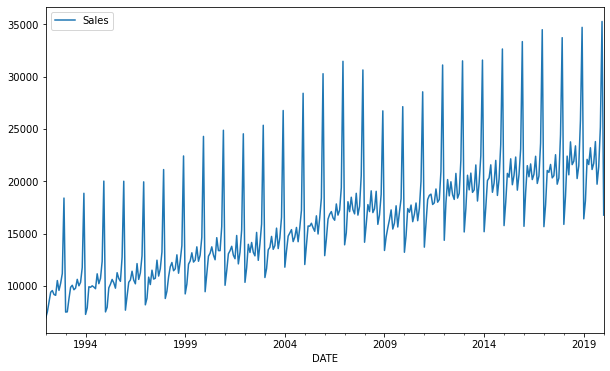

In [14]:
df.plot(figsize = (10,6))

## Train,Test Segregation

In [15]:
len(df)

337

In [16]:
len(df) - 18

319

In [18]:
test_ind = len(df) - 18

In [19]:
train = df[:test_ind]
test = df[test_ind:]

In [20]:
train.tail()

,Sales
DATE,
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


In [21]:
test.head()

,Sales
DATE,
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706


# Preprocessing Data

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [27]:
scaled_train = scaler.fit_transform(train)

In [28]:
scaled_test = scaler.transform(test)

# TimeSeriesGenerator

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
length = 12 # length of the batch
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size = 1)

In [32]:
X , y = generator[0]

In [33]:
X # Take the first twelve values and predict the next value i.e, thirteenth month

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [34]:
y

array([[0.02047633]])

# Model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout

In [44]:
n_features = 1

In [46]:
model = Sequential()

model.add(LSTM(240, return_sequences = True, input_shape = (length,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(240, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(120, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(120))
model.add(Dropout(0.2))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam',loss= 'mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 240)           232320    
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 240)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 240)           461760    
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 240)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 12, 120)           173280    
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 120)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 120)              

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(monitor='val_loss',patience = 2)

In [41]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size = 1)

In [53]:
model.fit_generator(generator,epochs = 14,validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 307 steps, validate for 6 steps
Epoch 1/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0025 - val_loss: 0.0231
Epoch 2/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 3/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 4/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 5/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 8/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 9/14
307/307 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 0.0133
Epoch 10

In [54]:
losses = pd.DataFrame(model.history.history)

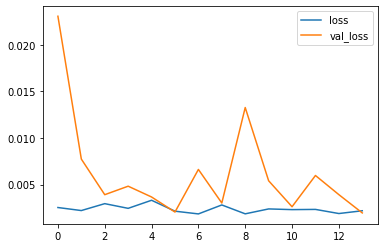

In [55]:
losses.plot()

## Predicting on Test Data

In [56]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0] # One time stamp ahead
    
    test_predictions.append(current_pred) # Append the prediction
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

In [57]:
true_predictions = scaler.inverse_transform(test_predictions)

In [58]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
test

,Sales,Predictions
DATE,,
2018-08-01,23381,22303.423773
2018-09-01,20260,19488.388351
2018-10-01,21473,19911.511740
2018-11-01,25831,24678.012056
2018-12-01,34706,32570.308149
2019-01-01,16410,16005.743364
2019-02-01,18134,18542.150769
2019-03-01,22093,22134.553333
2019-04-01,21597,20347.880770


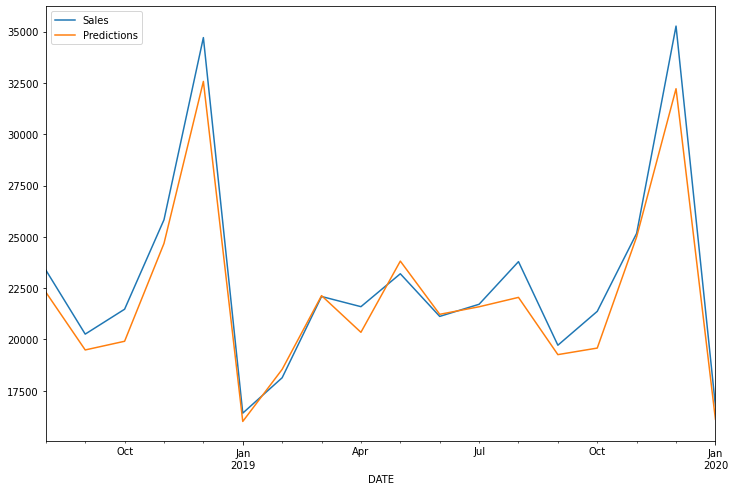

In [60]:
test.plot(figsize= (12,8))

## Forecasting Values

In [62]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [63]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [64]:
model = Sequential()

model.add(LSTM(240, return_sequences = True, input_shape = (length,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(240, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(120, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(120))
model.add(Dropout(0.2))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam',loss= 'mse')

In [66]:
model.fit_generator(generator,epochs = 14)

  ...
    to  
  ['...']
Train for 325 steps
Epoch 1/14
325/325 [==============================] - 6s 19ms/step - loss: 0.0272
Epoch 2/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0257
Epoch 3/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0189
Epoch 4/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0196
Epoch 5/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0183
Epoch 6/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0175
Epoch 7/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0155
Epoch 8/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0159
Epoch 9/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0162
Epoch 10/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0160
Epoch 11/14
325/325 [==============================] - 3s 8ms/step - loss: 0.0154
Epoch 12/14
325/325 [==============================] - 3s 8ms

In [67]:
forecast = []

periods = 12

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(periods):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

In [68]:
forecast = scaler.inverse_transform(forecast)

In [69]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-09-01,19719
2019-10-01,21369
2019-11-01,25169


In [70]:
forecast

array([[22281.16163826],
       [21903.68711758],
       [22944.89338923],
       [23994.49393034],
       [24523.9781146 ],
       [19334.33306646],
       [21641.81808853],
       [22822.86044502],
       [22642.30895185],
       [23213.0421133 ],
       [22627.13097   ],
       [22727.07908869]])

In [71]:
forecast_index = pd.date_range(start = '2020-02-01',periods = 12,freq="MS")

In [72]:
forecast_index

DatetimeIndex(['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [73]:
forecast_df = pd.DataFrame(data=forecast,index =forecast_index,columns=['Forecast'])

# Forecast DataFrame

In [74]:
forecast_df

,Forecast
2020-02-01,22281.161638
2020-03-01,21903.687118
2020-04-01,22944.893389
2020-05-01,23994.493930
2020-06-01,24523.978115
2020-07-01,19334.333066
2020-08-01,21641.818089
2020-09-01,22822.860445
2020-10-01,22642.308952
2020-11-01,23213.042113


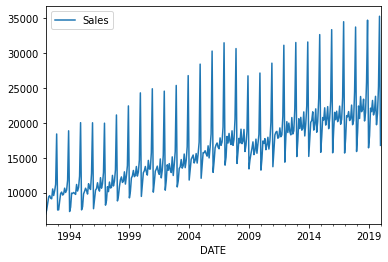

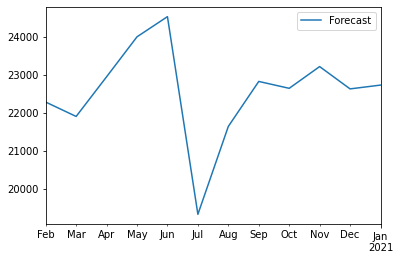

In [75]:
df.plot()
forecast_df.plot()

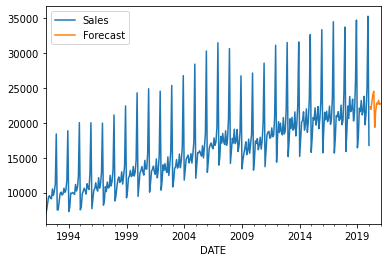

In [76]:
ax = df.plot()
forecast_df.plot(ax=ax)